# K-means Volume Curve

In [1]:
import sys
sys.path.append('C:\\Anaconda2\\Lib\\site-packages\\blpfunctions')
#import blpfunctions as blp
from blpfunctions import blpfunctions as blp
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans
#from sklearn.metrics import classification_report
import random
import matplotlib.gridspec as gridspec
from dateutil import rrule
from pandas.tseries.offsets import *
from holidays_jp import CountryHolidays
import dateutil.rrule as RR

def bbg_volcurve(ind, event, edate, numdays, interval,fld_lst):
    sec_list = blp.get_index(ind)
    #sec_list = ind
    volcurves = pd.DataFrame()
    fmt = "%Y-%m-%d" + 'T' + "%H:%M:%S"  #Assumes no milliseconds
    endDateTime = dt.datetime.strptime(edate, fmt)
   
    #skip SQ and holidays
    day1=dt.datetime(2016,1,1)
    sq = list(RR.rrule(RR.MONTHLY,byweekday=RR.FR,bysetpos=2,dtstart=day1,until=endDateTime))
    hols = list(zip(*CountryHolidays.get('JP', int(edate[0:4])))[0])
    skipdays = sq + hols
    bday_jp = CustomBusinessDay(holidays=skipdays)
    
    startDateTime = endDateTime.replace(hour=9) - numdays*bday_jp
    timedelta = pd.date_range(startDateTime, endDateTime, freq=bday_jp).nunique()
    sdate = startDateTime.strftime(fmt)
    
    for stock in sec_list:
        output=blp.get_Bars(stock, event, sdate, edate, interval, fld_lst)
        output.rename(columns={'VOLUME':stock},inplace=True)
        volcurves = volcurves.join(output,how="outer")

    #process the raw data into historical averages
    volcurves.rename(columns=lambda x: x[:4], inplace=True)
    timevect = pd.Series(volcurves.index.values)
    timeframet = timevect.to_frame()
    timeframet.columns =['date']
    timeframet.set_index(timevect,inplace=True)
    volcurves.set_index(timevect,inplace=True)#timezone hack
    timeframet['bucket'] = timeframet['date'].apply(lambda x: dt.datetime.strftime(x, '%H:%M:%S'))
    timeframet=timeframet.join(volcurves)
    volcurvesum=timeframet.groupby(['bucket']).sum()
    adv = volcurvesum.sum()/timedelta
    volcurves = volcurvesum / volcurvesum.sum()
    volcurves = volcurves.cumsum()
    volcurves = volcurves.interpolate()
    volcurvesum = volcurvesum.interpolate()
    volcurvesum = volcurvesum.dropna(axis=1,how='all')
    
    return adv, volcurvesum.fillna(method='bfill'), volcurves.fillna(method='bfill')

In [2]:
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return np.sqrt(LB_sum)


In [3]:
#Return centroids of clusters
def k_means_clust(volcurve,num_clust,num_iter,w=4):
    centroid_list=random.sample(volcurve.columns.values,num_clust)
    if '3103' not in centroid_list:
        centroid_list.append('3103')
    centroids = volcurve[centroid_list]
    counter=0
    for n in range(num_iter):
        counter+=1
        print "Iteration: ", counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(volcurve):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(volcurve[i],centroids[j],5)<min_dist:
                    #cur_dist=DTWDistance(volcurve[i],centroids[j],w)
                    cur_dist=np.linalg.norm(volcurve[i]-centroids[j])
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            
            if closest_clust in assignments:
                assignments[closest_clust].append(i)
            else:
                assignments[closest_clust]=[]
                
        assignments = {i:j for i,j in assignments.items() if i is not None}
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=np.zeros(shape=len(volcurve))
            if assignments[key]:
                for k in assignments[key]:
                    clust_sum = clust_sum + np.transpose(volcurve[k].values)  
                centroids.columns = assignments.keys()
                centroids[key]=clust_sum/len(assignments[key])
                
    centroids.reindex(index=volcurve.index.values) 
    
    return centroids

#Assign test data to centroids
def assignments(test, centroids, w):
    assignments={}
    dists = []
    for ind, i in enumerate(test):
        min_dist=float('inf')
        cur_dist=float('inf')
        closest_clust=None    
        for c_ind,j in enumerate(centroids):
            if LB_Keogh(test[i],centroids[j],5)<min_dist:
                #cur_dist=DTWDistance(test[i],centroids[j],w)
                cur_dist=np.linalg.norm(volcurve[i]-centroids[j])
                if cur_dist<min_dist:
                    min_dist=cur_dist
                    closest_clust=c_ind
        
        if assignments.has_key(closest_clust):       
            assignments[closest_clust].append(i)
        else:
            assignments[closest_clust]=[]
            assignments[closest_clust].append(i)
        
        dists.append((i,min_dist))
        
    return assignments, dists              

In [4]:
#create the volume curves
ind = "NKY Index"
fld = ["VOLUME"]
event = ["TRADE"]
#sd = "2016-08-05T09:00:00"
ed = "2017-09-20T15:00:00"
iv = 5 #5-minute bars

#sd1 = "2016-09-08T09:00:00"
ed1 = "2017-09-21T15:00:00"

adv20s, rawcurve, volcurve = bbg_volcurve(ind,event,ed,20,iv,fld)
#volcurve.pop('3103')
#adv20s.pop('3103')
#rawcurve.pop('3103')
test_adv20s, test_raw, test = bbg_volcurve(ind,event,ed1,0,iv,fld)
#test.pop('3103')
#test_raw.pop('3103')
#cumcurv = read_volcurve("R:\\Users\\4126694\\Python\\Data\\nky-test1.csv")
#cumcurvt= read_volcurve("R:\\Users\\4126694\\Python\\Data\\testdata1.csv")

In [8]:
#Find and return the best centroids and assignments
def find_min(windmax, clustmin, clustmax, iters=3):
    result =[]
    minima =float('inf')
    #for wind in range(5,windmax):
    wind = windmax
    for numclusts in range(clustmin,clustmax):
        #print "Window: ", wind, " Clusts: ", numclusts
        centroids = k_means_clust(volcurve,numclusts,iters,wind)
        ass, dists = assignments(volcurve,centroids,wind)
        foo = pd.DataFrame(dists,columns=['sym','dist'])
        avedist = foo['dist'].mean()
        result.append([wind, numclusts, avedist])
        if avedist < minima:
            minima = avedist
            bestroids = centroids
            bestass = ass
    return result, bestroids, bestass

maxwindsize = 9
minclusts = 9
maxclusts = 15
iterations = 10

results, centroids, assignments = find_min(maxwindsize,minclusts,maxclusts,iterations)

 Iteration:  1


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10


In [9]:
results

[[9, 9, 0.10682617013222269],
 [9, 10, 0.10384727544861361],
 [9, 11, 0.0991962459058584],
 [9, 12, 0.09512111288419554],
 [9, 13, 0.09389519569488117],
 [9, 14, 0.09200856629605843]]

In [7]:
num_clust = 10
wind = 5
num_iter=10
centroids = k_means_clust(num_clust,num_iter,wind)
asses, dists = assignments(volcurve,centroids,wind)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
#plot
#num_clust = 10

#num_iter = 100
#wind = 5
#centroids = k_means_clust(volcurve,num_clust,num_iter,wind);
#asses, dists = assignments(volcurve, centroids, wind);

import matplotlib.gridspec as gridspec

ncols = 5
nrows = 3
#nrows = int(round(num_clust/3.0) + 1)
#gs = gridspec.GridSpec(nrows,ncols)
gs_top = plt.GridSpec(nrows, ncols, top=0.85)
gs_base = plt.GridSpec(nrows, ncols, hspace=0.8)
fig = plt.figure()
fig.autofmt_xdate()
ax1 = fig.add_subplot(gs_top[0,:])


centroids.plot(figsize=(20,20),ax=ax1)
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width*0.96, box.height])
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title("Volume Curve Groups")

for key,value in assignments.iteritems():
    i = key
    #ax = fig.add_subplot(nrows,ncols,i,sharex=ax)
    if i < 5:
        ax = fig.add_subplot(gs_base[1,i])
    else:
        ax = fig.add_subplot(gs_base[2,i-5])
    handles, labels = ax1.get_legend_handles_labels()
    ax.plot(volcurve[value].values)
    ax.set_title("Group: " + str(key))
    box1 = ax.get_position()
    ax.set_position([box1.x0, box1.y0, box1.width * 0.8, box1.height])
    ax.legend(value,fontsize=8,loc=2, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylim([0.0,1.0])
ax.set_ylim([0.0,1.0])
plt.figure(figsize=(11,4))
plt.show()
#fig.savefig("R:\\Users\\4126694\\Python\\Data\\volcurve0428DTW.pdf")
fig.savefig("R:\\Users\\4126694\\Python\\Data\\volcurves0908.png")

IndexError: index out of range

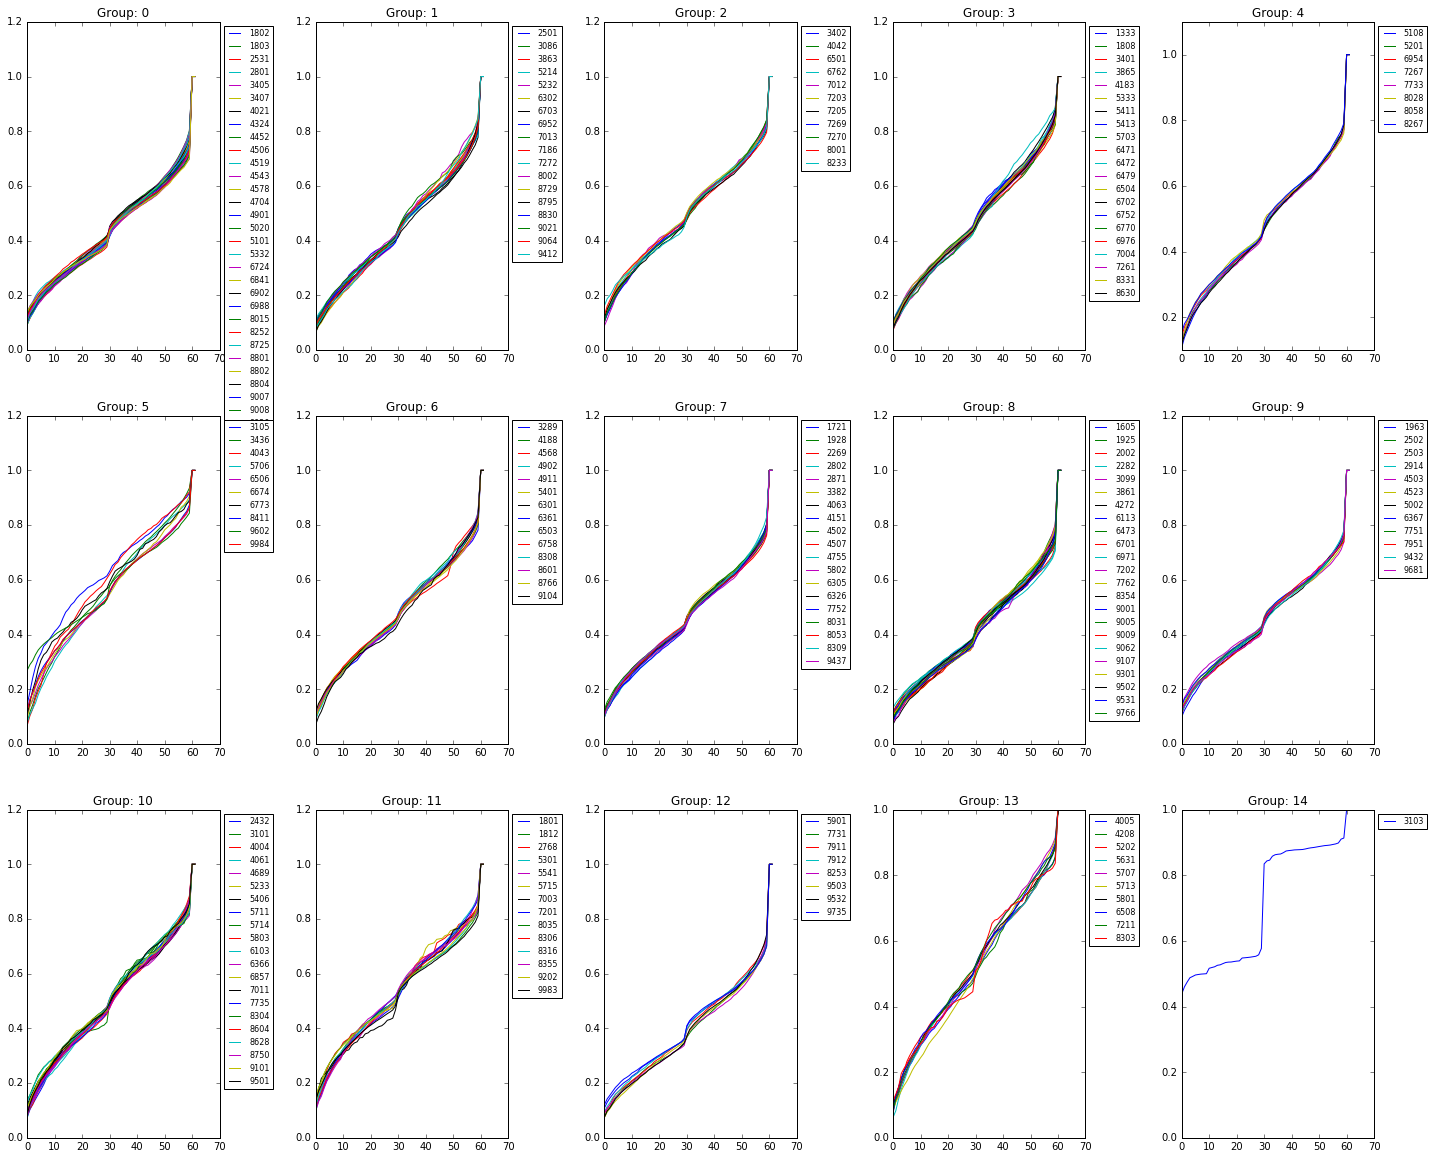

In [16]:
#plot
#num_clust = 10

#num_iter = 100
#wind = 5
#centroids = k_means_clust(volcurve,num_clust,num_iter,wind);
#asses, dists = assignments(volcurve, centroids, wind);

import matplotlib.gridspec as gridspec
%matplotlib inline

ncols = 5
nrows = 2
#nrows = int(round(num_clust/3.0) + 1)
#gs = gridspec.GridSpec(nrows,ncols)
#gs_top = plt.GridSpec(nrows, ncols, top=0.85)
#gs_base = plt.GridSpec(nrows, ncols)
fig = plt.figure(figsize=(25, 20))
#fig.autofmt_xdate()
#ax1 = fig.add_subplot(gs_top[0,:])


#centroids.plot(figsize=(20,20),ax=ax1)
#box = ax1.get_position()
#ax1.set_position([box.x0, box.y0, box.width*0.96, box.height])
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax1.set_title("Volume Curve Groups")

gs=gridspec.GridSpec(3,5)

for key,value in assignments.iteritems():
    i = key+1
    #ax = fig.add_subplot(nrows,ncols,i,sharex=ax)
    '''
    if i < 5:
        ax = fig.add_subplot(gs_base[1,i])
    else:
        ax = fig.add_subplot(gs_base[2,i-5])
    '''
    ax = fig.add_subplot(3,5,i)
    #ax = plt.subplot(gs[i])
    handles, labels = ax1.get_legend_handles_labels()
    ax.plot(volcurve[value].values)
    ax.set_title("Group: " + str(key))
    box1 = ax.get_position()
    ax.set_position([box1.x0, box1.y0, box1.width * 0.8, box1.height])
    ax.legend(value,fontsize=8,loc=2, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylim([0.0,1.0])
ax.set_ylim([0.0,1.0])
#plt.figure(figsize=(20,15))

plt.show()
#fig.savefig("R:\\Users\\4126694\\Python\\Data\\volcurve0428DTW.pdf")
fig.savefig("R:\\Users\\4126694\\Python\\Data\\volcurves0908.png",transparent=True)

In [8]:
X = volcurve.T
mytarget_names = list(volcurve.columns.values)
tasses, tdists = assignments(test,centroids,wind)
testtargetdict={}
targetdict ={}
y =[]
for targ in mytarget_names:
    for key, val in asses.iteritems():
        if targ in val:
            targetdict[targ]=key
            #y.append(key)
for targ in mytarget_names:
    for key, val in tasses.iteritems():
        if targ in val:
            testtargetdict[targ]=key

In [13]:
range(5,6)

[5]

In [9]:
hcerror={}
cerror={}
stockerror={}

#slippage vs. historical assignments
for key, val in targetdict.iteritems():
    hcerror[key] = Euclid(test[key],centroids[val])
    stockerror[key] = Euclid(test[key],volcurve[key])

#slippage based on current assignment 
for key, val in testtargetdict.iteritems():
    cerror[key] = Euclid(test[key],centroids[val])
    
    
errors = pd.DataFrame({'vs. hist cent':hcerror, 'vs hist stock':stockerror,'vs. tday centroid':cerror})

In [10]:
#How many stocks trade according to historical assignments?
clust_comps = pd.DataFrame({'hist':targetdict,'tday':testtargetdict})
clust_comps[clust_comps['hist'] == clust_comps['tday']].count() 

hist    44
tday    44
dtype: int64

In [13]:
errors.describe()

,vs hist stock,vs. hist cent,vs. tday centroid
count,223.000000,223.000000,223.000000
mean,0.428696,0.434185,0.272743
std,0.269372,0.282573,0.163945
min,0.082690,0.094756,0.079448
25%,0.242504,0.240296,0.186268
50%,0.370126,0.357031,0.233841
75%,0.533913,0.521420,0.319607
max,1.689975,1.781513,1.417841


In [ ]:
#instead of the DTW distance, we just use Euclidean distance
def Euclid_kmeans(data,num_clust,num_iter,w=4):
    centroid_list=random.sample(data.columns.values,num_clust)
    centroids = data[centroid_list]
    counter=0
    for n in range(num_iter):
        counter+=1
        #print "Iteration: ", counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(data[i],centroids[j],5)<min_dist:
                    cur_dist=Euclid(data[i],centroids[j])
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            
            if closest_clust in assignments:
                assignments[closest_clust].append(i)
            else:
                assignments[closest_clust]=[]

        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=np.zeros(shape=len(data))
            if assignments[key]:
                for k in assignments[key]:
                    clust_sum = clust_sum + np.transpose(data[k].values)  
                centroids.columns = assignments.keys()
                centroids[key]=clust_sum/len(assignments[key])
                
    centroids.reindex(index=data.index.values) 
    
    return centroids


def Euclid_assignments(test, centroids, w=4):
    assignments={}
    dists = []
    for ind, i in enumerate(test):
        min_dist=float('inf')
        closest_clust=None    
        for c_ind,j in enumerate(centroids):
            if LB_Keogh(test[i],centroids[j],5)<min_dist:
                        cur_dist=Euclid(test[i],centroids[j])
                        if cur_dist<min_dist:
                            min_dist=cur_dist
                            closest_clust=c_ind
        
        if assignments.has_key(closest_clust):       
            assignments[closest_clust].append(i)
        else:
            assignments[closest_clust]=[]
            assignments[closest_clust].append(i)
        
        dists.append((i,min_dist))
        
    return assignments, dists 

In [ ]:
X = volumes.T
Xsm = X[['09:00:00', '11:25:00', '14:50:00']]
Xsm['14:50:00'] = 1 - Xsm['14:50:00'] 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import animation


threedee = plt.figure().gca(projection='3d')
threedee.set_xlabel('Open')
threedee.set_ylabel('AMCls')
threedee.set_zlabel('Close')
threedee.view_init(elev=0., azim=0)

threedee.scatter(Xsm['09:00:00'], Xsm['11:25:00'], Xsm['14:50:00'])

plt.show()

In [ ]:
feature_names = list(X.columns.values)
mytarget_names = list(volcurve.columns.values)
targetdict ={}
y =[]
for targ in mytarget_names:
    for key, val in assignments.iteritems():
        if targ in val:
            targetdict[targ]=key
            y.append(key)

In [ ]:
from sklearn import decomposition
from matplotlib import animation

centers = [[1, 1], [-1, -1], [1, -1]]


fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [('A', 0), ('B', 1), ('C', 2), ('D', 3), ('E', 4), ('F', 5), ('G', 6), ('H', 7)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean(),
              X[y == label, 2].mean(), name,
              horizontalalignment='center', 
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0, 3, 4, 5, 6, 7]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.spectral)

x_surf = [X[:, 0].min(), X[:, 0].max(),
          X[:, 0].min(), X[:, 0].max()]
y_surf = [X[:, 0].max(), X[:, 0].max(),
          X[:, 0].min(), X[:, 0].min()]
x_surf = np.array(x_surf)
y_surf = np.array(y_surf)
v0 = pca.transform(pca.components_[[0]])
v0 /= v0[-1]
v1 = pca.transform(pca.components_[[1]])
v1 /= v1[-1]

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

In [1]:
def assign(predict, centroids, w, sym, t_ind, lookback):
    min_dist=float('inf')
    cur_dist=float('inf')
    closest_clust=None
    start = 0
    if t_ind > lookback:
        start = t_ind-lookback
    else:
        start = 0
    for c_ind,j in enumerate(centroids):
        if LB_Keogh(predict[sym][start:t_ind],centroids[j][start:t_ind],3)<min_dist:
            cur_dist=DTWDistance(predict[sym][start:t_ind],centroids[j][start:t_ind],w)
            #cur_dist=Euclid(predict[sym][start:t_ind],centroids[j][start:t_ind])
            if cur_dist<min_dist:
                min_dist=cur_dist
                closest_clust=c_ind 
    return closest_clust


 #Look at the raw volume on the test day, need tot embed as a function
prediction = pd.DataFrame(0.0,index=test_raw.index.values,columns=test_raw.columns.values)
error = pd.DataFrame(0.0,index=test_raw.index.values,columns=test_raw.columns.values)
centpred = pd.DataFrame(0.0,index=test_raw.index.values,columns=test_raw.columns.values)
cumtestraw=test_raw.cumsum()
cumerror={}

'''
Simple Volume Curve Prediction
1. Calculate the scaler as the ratio of pred_open_vol/actual_open_vol
2. Comupte the multiplier for every time bucket (actual/predicted)
3. Compute the estimated full-day volume
4. 
'''

for ind, sym in enumerate(test_raw):
    ocent = targetdict[sym] #get the initial centroid assignment 
    cent = ocent
    cumerr = 0
    adv = adv20s[sym]
    sumnorm = cumvol = cumpred = cumact = 0
    scaler=1
    lookback = 5 #4 Seems to give the best results
    prediction[sym] = centroids[ocent].copy()
    for t_ind, t in enumerate(test_raw.index.values):
        #tstart = t_ind - lookback
        centpred[sym][t] = cent
        
        prediction[sym][t_ind+1:] = centroids[cent][t_ind+1:].copy()       
      
        error[sym][t] = (prediction[sym][t_ind]-test[sym][t_ind])**2
        cumerr = cumerr + error[sym][t]
        
        if error[sym][t_ind] > 0.0001:
        #if np.mod(t_ind,30) == 0:
            cent = assign(test,centroids,6,sym,t_ind) #using t_ind/2 as lookback
            #cent = assign(prediction,centroids,6,sym,t_ind)
    cumerror[sym] = cumerr

for ind, sym in enumerate(centpred):
    for tind, t in enumerate(centpred.index.values):
        roid = centpred[sym][tind]
        oprediction[sym][t] = centroids[roid][tind]

'''
Compute the Errors
'''
hcerror={}
cerror={}
stockerror={}
prederror={}

#slippage vs. historical assignments
for key, val in targetdict.iteritems():
    hcerror[key] = Euclid(test[key],centroids[val])
    stockerror[key] = Euclid(test[key],volcurve[key])

#slippage based on current assignment 
for key, val in testtargetdict.iteritems():
    cerror[key] = Euclid(test[key],centroids[val])
    prederror[key] = Euclid(test[key],prediction[key])
        
errors = pd.DataFrame({'real vs. hist cent':hcerror, 'real vs hist stock':stockerror,'real vs. lookbak':cerror, 'vs. real vs. pred':prederror})
errors.describe()        

NameError: name 'pd' is not defined

# Random Forest Classifier of Volume Curves

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

X = volcurve.T

feature_names = list(X.columns.values)
mytarget_names = list(volcurve.columns.values)
targetdict ={}

indexlist =[]
imps = []
y =[]
for targ in mytarget_names:
    for key, val in asses.iteritems():
        if targ in val:
            targetdict[targ]=key
            y.append(key)

x_test = test.T
y_test = []
for targ in mytarget_names:
    for key, val in tasses.iteritems():
        if targ in val:
            testtargetdict[targ]=key
            y_test.append(key)

rf = RandomForestClassifier(n_estimators=1000, max_features = 15)
#rf = LogisticRegression()

rf.fit(X.as_matrix(), y)

probs = rf.predict_proba(x_test.as_matrix())
for feature, imp in zip(feature_names, rf.feature_importances_):
    imps.append(imp)
    indexlist.append(feature)

proba=[]
col_ind = np.argsort(probs,axis=1)[:,-1]
for i in range(len(col_ind)):
    j = col_ind[i]
    proba.append(probs[i][j])


importance = pd.DataFrame({'Importance':imps},index=indexlist)

bina = [c==d for c, d in zip (y,y_test)]

fpr, tpr, _ = roc_curve(bina, proba)
roc_auc = auc(fpr, tpr)
print roc_auc
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [18]:
np.save('clusters.npy', assignments) 